#### Colab setup

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
%cd "gdrive/My Drive/Colab Notebooks"

#### Imports

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

In [3]:
import common
import prune
from data import get_mnist, get_cifar
from experiment import Experiment
from models import LeNet_300_100, Conv2

In [4]:
#np.random.seed(common.SEED)
#torch.manual_seed(common.SEED)

In [5]:
pruning_methods = [prune.max_fp_pruning, prune.min_fp_pruning, prune.max_ip_pruning, prune.min_ip_pruning, prune.max_fp_mod_pruning, prune.min_fp_mod_pruning, prune.max_mag_pruning, prune.min_mag_pruning]

In [6]:
def compare_pruning(experiment, testloader, layer, n_rounds, pruning_ratio, *, include_random=False, save_results=False):
    if include_random:
      print("Random pruning experiment:\n")
      exp_acc, exp_fps = prune.random_pruning_rounds(experiment, testloader, layer, n_rounds, 
                                               pruning_ratio, save_results=save_results)
    else:
      exp_acc = []
      exp_fps = []
    
    pruning_accuracies = {}
    pruning_fps = {}
    for pruning in pruning_methods:
        pruning_method = pruning.__name__
        print("Pruning using:", pruning_method)
        experiment.init_model()
        acc, fps = prune.prune_and_test(experiment, testloader, layer, pruning, 
                                         pruning_ratio, save_results=False)
        pruning_accuracies[pruning_method] = acc
        pruning_fps[pruning_method] = fps
        
    if save_results:
      prune.save_pruning_meta(experiment.model, layer, "combined", pruning_ratio, pruning_accuracies, pruning_fps)
    
    return exp_acc, exp_fps, pruning_accuracies, pruning_fps

In [7]:
def draw_acc_plot(layer, fname_exp_acc, fname_pruning_acc, *, figsize=(25, 12), fig_name=""):  
    plt.figure(figsize=figsize)
    
    pruning_acc = np.load(fname_pruning_acc, allow_pickle=True).item()
    for pruning_method, acc in pruning_acc.items():
        n_obs = len(acc)
        plt.plot(acc, label=pruning_method)
        
    if fname_exp_acc:
      exp_acc = np.load(fname_exp_acc)
      random_accuracies = exp_acc.mean(axis=0)
      random_std_devs = exp_acc.std(axis=0)
      plt.errorbar(range(n_obs), random_accuracies, random_std_devs, linestyle='None', 
                   marker='.', label="random pruning")
    
    plt.title("Accuracy after pruning " + layer)
    elem_type = "neurons" if layer[:2] == "fc" else "filters"
    plt.xlabel("Pruned " + elem_type)
    plt.ylabel("Accuracy (%)")
    plt.legend(loc="best")
    
    if fig_name:
        fig_path = os.path.join(common.FIGURE_PATH, fig_name)
        plt.savefig(fig_path, format="png")
    else:
        plt.show()

In [8]:
def draw_fps_plot(layer, fname_exp_fps, fname_pruning_fps, *, figsize=(25, 12), fig_name=""):
    plt.figure(figsize=figsize)
    
    pruning_fps = np.load(fname_pruning_fps, allow_pickle=True).item()
    for pruning_method, fps in pruning_fps.items():
        n_obs = len(fps)
        plt.plot(fps, label=pruning_method)
        
    if fname_exp_fps:
      exp_fps = np.load(fname_exp_fps)
      random_fps = exp_fps.mean(axis=0)
      random_std_devs = exp_fps.std(axis=0)
      plt.errorbar(range(n_obs), random_fps, random_std_devs, linestyle='None', 
                   marker='.', label="random pruning")
    
    plt.title("Frame potential after pruning " + layer)
    elem_type = "neurons" if layer[:2] == "fc" else "filters"
    plt.xlabel("Pruned " + elem_type)
    plt.ylabel("FP")
    plt.legend(loc="best")
    
    if fig_name:
        fig_path = os.path.join(common.FIGURE_PATH, fig_name)
        plt.savefig(fig_path, format="png")
    else:
        plt.show()

In [9]:
def draw_sched_plot(layer, acc_fname, pruning_method, pruning_ratio, *, figsize=(14, 7), fig_name=""):
  plt.figure(figsize=figsize)
  
  accuracies = np.load(acc_fname, allow_pickle=True).item()
  for init_time, acc in accuracies.items():
    if init_time == -1:
      plt.plot(accuracies[init_time], label="No pruning")
    elif init_time == 0:
      plt.plot(accuracies[init_time], label="{}% random_pruning before training".format(int(pruning_ratio*100)))
    else:
      plt.plot(accuracies[init_time], label="{}% {} after iteration {}".format(int(pruning_ratio*100), pruning_method, init_time))
  plt.title(f"Testset accuracy (pruning {layer})")
  plt.xlabel("Time")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc="best")
  
  if fig_name:
      fig_path = os.path.join(common.FIGURE_PATH, fig_name)
      plt.savefig(fig_path, format="png")
  else:
      plt.show()

In [10]:
def load_state_dict(model_name):
    model_fname = os.path.join(common.MODEL_PATH, model_name)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    return torch.load(model_fname, map_location=device)

In [11]:
def mnist_pruning(testloader, layers, *, model_name="LeNet_300_100_01-10-2019_10:13:45", pruning_ratio=0.9, include_random=False, n_rounds=0, save_results=True):
  optim_kwargs = {'lr': 0.003, 'momentum': 0.9}
  model = LeNet_300_100()
  model_state = load_state_dict(model_name)
  model.load_state_dict(model_state)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), **optim_kwargs)
  e = Experiment(model, criterion, optimizer, optim_kwargs, model_state=model_state)
  for layer in layers:
    exp_acc, exp_fps, pruning_accuracies, pruning_fps = compare_pruning(e, testloader, layer, n_rounds, pruning_ratio, include_random=include_random, save_results=save_results)
    
  return exp_acc, exp_fps, pruning_accuracies, pruning_fps

In [12]:
def cifar_pruning(testloader, layers, *, model_name="Conv2_01-10-2019_12:37:35", pruning_ratio=0.9, include_random=False, n_rounds=0, save_results=True):
  optim_kwargs = {'lr': 0.0002}
  model = Conv2()
  model_state = load_state_dict(model_name)
  model.load_state_dict(model_state)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), **optim_kwargs)
  e = Experiment(model, criterion, optimizer, optim_kwargs, model_state=model_state)
  for layer in layers:
    exp_acc, exp_fps, pruning_accuracies, pruning_fps = compare_pruning(e, testloader, layer, n_rounds, pruning_ratio, include_random=include_random, save_results=save_results)
  
  return exp_acc, exp_fps, pruning_accuracies, pruning_fps

In [13]:
def cifar_scheduling(testloader, layers, pruning, pruning_ratios, *, epochs=5, test_interval=50, saving_times=[1, 8, 40], save_results=True):
  for pruning_ratio in pruning_ratios:
    optim_kwargs = {'lr': 0.0002}
    model = Conv2()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), **optim_kwargs)
    e = Experiment(model, criterion, optimizer, optim_kwargs)
    accuracies, frame_potentials = prune.pruning_schedule(e, trainloader, testloader, epochs, test_interval, saving_times, layers, pruning, pruning_ratio, save_results=save_results)
  return accuracies, frame_potentials

## MNIST / Lenet 300-100-10

### Loading the data

In [14]:
train_batch_size = 16
test_batch_size = 1000

In [15]:
trainloader, testloader, classes = get_mnist(train_batch_size, test_batch_size)

### Training the model

In [16]:
epochs = 20
optim_kwargs = {'lr': 0.003, 'momentum': 0.9}

In [17]:
model = LeNet_300_100(bias=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), **optim_kwargs)
e = Experiment(model, criterion, optimizer, optim_kwargs)
monitored = ['fc1', 'fc2']

In [18]:
test_accuracies = e.fit(trainloader, testloader, epochs, monitored=monitored, save_results=True)


Test set: Average loss: 2.3078, Accuracy:   1224/ 10000 (12%)

Created model snapshot directory: out/models/LeNet_300_100_21-10-2019_15:25:45
Train Epoch:   1 [     0/ 60000 (0%)]	Loss: 2.297339
Train Epoch:   1 [  1600/ 60000 (3%)]	Loss: 0.981066
Train Epoch:   1 [  3200/ 60000 (5%)]	Loss: 0.464690
Train Epoch:   1 [  4800/ 60000 (8%)]	Loss: 0.543019
Train Epoch:   1 [  6400/ 60000 (11%)]	Loss: 0.118098
Train Epoch:   1 [  8000/ 60000 (13%)]	Loss: 0.626859
Train Epoch:   1 [  9600/ 60000 (16%)]	Loss: 0.292227
Train Epoch:   1 [ 11200/ 60000 (19%)]	Loss: 0.844086
Train Epoch:   1 [ 12800/ 60000 (21%)]	Loss: 0.408728
Train Epoch:   1 [ 14400/ 60000 (24%)]	Loss: 0.418998
Train Epoch:   1 [ 16000/ 60000 (27%)]	Loss: 0.150357
Train Epoch:   1 [ 17600/ 60000 (29%)]	Loss: 0.135643
Train Epoch:   1 [ 19200/ 60000 (32%)]	Loss: 0.188149
Train Epoch:   1 [ 20800/ 60000 (35%)]	Loss: 0.062210
Train Epoch:   1 [ 22400/ 60000 (37%)]	Loss: 0.164477
Train Epoch:   1 [ 24000/ 60000 (40%)]	Loss: 0.0788

Train Epoch:   4 [ 51200/ 60000 (85%)]	Loss: 0.023423
Train Epoch:   4 [ 52800/ 60000 (88%)]	Loss: 0.181666
Train Epoch:   4 [ 54400/ 60000 (91%)]	Loss: 0.010917
Train Epoch:   4 [ 56000/ 60000 (93%)]	Loss: 0.038075
Train Epoch:   4 [ 57600/ 60000 (96%)]	Loss: 0.001806
Train Epoch:   4 [ 59200/ 60000 (99%)]	Loss: 0.006408

Test set: Average loss: 0.0844, Accuracy:   9734/ 10000 (97%)

Train Epoch:   5 [     0/ 60000 (0%)]	Loss: 0.002814
Train Epoch:   5 [  1600/ 60000 (3%)]	Loss: 0.512003
Train Epoch:   5 [  3200/ 60000 (5%)]	Loss: 0.026520
Train Epoch:   5 [  4800/ 60000 (8%)]	Loss: 0.014745
Train Epoch:   5 [  6400/ 60000 (11%)]	Loss: 0.001310
Train Epoch:   5 [  8000/ 60000 (13%)]	Loss: 0.010484
Train Epoch:   5 [  9600/ 60000 (16%)]	Loss: 0.008093
Train Epoch:   5 [ 11200/ 60000 (19%)]	Loss: 0.122102
Train Epoch:   5 [ 12800/ 60000 (21%)]	Loss: 0.013142
Train Epoch:   5 [ 14400/ 60000 (24%)]	Loss: 0.007799
Train Epoch:   5 [ 16000/ 60000 (27%)]	Loss: 0.000806
Train Epoch:   5 [ 176

Train Epoch:   8 [ 44800/ 60000 (75%)]	Loss: 0.000124
Train Epoch:   8 [ 46400/ 60000 (77%)]	Loss: 0.007737
Train Epoch:   8 [ 48000/ 60000 (80%)]	Loss: 0.006459
Train Epoch:   8 [ 49600/ 60000 (83%)]	Loss: 0.000280
Train Epoch:   8 [ 51200/ 60000 (85%)]	Loss: 0.000520
Train Epoch:   8 [ 52800/ 60000 (88%)]	Loss: 0.013046
Train Epoch:   8 [ 54400/ 60000 (91%)]	Loss: 0.000862
Train Epoch:   8 [ 56000/ 60000 (93%)]	Loss: 0.012621
Train Epoch:   8 [ 57600/ 60000 (96%)]	Loss: 0.000270
Train Epoch:   8 [ 59200/ 60000 (99%)]	Loss: 0.010056

Test set: Average loss: 0.0832, Accuracy:   9791/ 10000 (98%)

Train Epoch:   9 [     0/ 60000 (0%)]	Loss: 0.000614
Train Epoch:   9 [  1600/ 60000 (3%)]	Loss: 0.231478
Train Epoch:   9 [  3200/ 60000 (5%)]	Loss: 0.001956
Train Epoch:   9 [  4800/ 60000 (8%)]	Loss: 0.003655
Train Epoch:   9 [  6400/ 60000 (11%)]	Loss: 0.000067
Train Epoch:   9 [  8000/ 60000 (13%)]	Loss: 0.002336
Train Epoch:   9 [  9600/ 60000 (16%)]	Loss: 0.000362
Train Epoch:   9 [ 112

Train Epoch:  12 [ 38400/ 60000 (64%)]	Loss: 0.000819
Train Epoch:  12 [ 40000/ 60000 (67%)]	Loss: 0.000046
Train Epoch:  12 [ 41600/ 60000 (69%)]	Loss: 0.000160
Train Epoch:  12 [ 43200/ 60000 (72%)]	Loss: 0.000856
Train Epoch:  12 [ 44800/ 60000 (75%)]	Loss: 0.000025
Train Epoch:  12 [ 46400/ 60000 (77%)]	Loss: 0.000997
Train Epoch:  12 [ 48000/ 60000 (80%)]	Loss: 0.000406
Train Epoch:  12 [ 49600/ 60000 (83%)]	Loss: 0.000362
Train Epoch:  12 [ 51200/ 60000 (85%)]	Loss: 0.000049
Train Epoch:  12 [ 52800/ 60000 (88%)]	Loss: 0.005391
Train Epoch:  12 [ 54400/ 60000 (91%)]	Loss: 0.000065
Train Epoch:  12 [ 56000/ 60000 (93%)]	Loss: 0.000481
Train Epoch:  12 [ 57600/ 60000 (96%)]	Loss: 0.000049
Train Epoch:  12 [ 59200/ 60000 (99%)]	Loss: 0.000211

Test set: Average loss: 0.0795, Accuracy:   9818/ 10000 (98%)

Train Epoch:  13 [     0/ 60000 (0%)]	Loss: 0.000005
Train Epoch:  13 [  1600/ 60000 (3%)]	Loss: 0.020360
Train Epoch:  13 [  3200/ 60000 (5%)]	Loss: 0.001385
Train Epoch:  13 [  4

Train Epoch:  16 [ 32000/ 60000 (53%)]	Loss: 0.000796
Train Epoch:  16 [ 33600/ 60000 (56%)]	Loss: 0.000365
Train Epoch:  16 [ 35200/ 60000 (59%)]	Loss: 0.000580
Train Epoch:  16 [ 36800/ 60000 (61%)]	Loss: 0.000009
Train Epoch:  16 [ 38400/ 60000 (64%)]	Loss: 0.000509
Train Epoch:  16 [ 40000/ 60000 (67%)]	Loss: 0.000019
Train Epoch:  16 [ 41600/ 60000 (69%)]	Loss: 0.000158
Train Epoch:  16 [ 43200/ 60000 (72%)]	Loss: 0.000399
Train Epoch:  16 [ 44800/ 60000 (75%)]	Loss: 0.000023
Train Epoch:  16 [ 46400/ 60000 (77%)]	Loss: 0.001740
Train Epoch:  16 [ 48000/ 60000 (80%)]	Loss: 0.000059
Train Epoch:  16 [ 49600/ 60000 (83%)]	Loss: 0.000324
Train Epoch:  16 [ 51200/ 60000 (85%)]	Loss: 0.000002
Train Epoch:  16 [ 52800/ 60000 (88%)]	Loss: 0.001408
Train Epoch:  16 [ 54400/ 60000 (91%)]	Loss: 0.000054
Train Epoch:  16 [ 56000/ 60000 (93%)]	Loss: 0.000140
Train Epoch:  16 [ 57600/ 60000 (96%)]	Loss: 0.000009
Train Epoch:  16 [ 59200/ 60000 (99%)]	Loss: 0.000034

Test set: Average loss: 0.0

Train Epoch:  20 [ 25600/ 60000 (43%)]	Loss: 0.000136
Train Epoch:  20 [ 27200/ 60000 (45%)]	Loss: 0.000163
Train Epoch:  20 [ 28800/ 60000 (48%)]	Loss: 0.000072
Train Epoch:  20 [ 30400/ 60000 (51%)]	Loss: 0.000019
Train Epoch:  20 [ 32000/ 60000 (53%)]	Loss: 0.000588
Train Epoch:  20 [ 33600/ 60000 (56%)]	Loss: 0.000268
Train Epoch:  20 [ 35200/ 60000 (59%)]	Loss: 0.000330
Train Epoch:  20 [ 36800/ 60000 (61%)]	Loss: 0.000007
Train Epoch:  20 [ 38400/ 60000 (64%)]	Loss: 0.000391
Train Epoch:  20 [ 40000/ 60000 (67%)]	Loss: 0.000016
Train Epoch:  20 [ 41600/ 60000 (69%)]	Loss: 0.000164
Train Epoch:  20 [ 43200/ 60000 (72%)]	Loss: 0.000265
Train Epoch:  20 [ 44800/ 60000 (75%)]	Loss: 0.000013
Train Epoch:  20 [ 46400/ 60000 (77%)]	Loss: 0.001150
Train Epoch:  20 [ 48000/ 60000 (80%)]	Loss: 0.000036
Train Epoch:  20 [ 49600/ 60000 (83%)]	Loss: 0.000236
Train Epoch:  20 [ 51200/ 60000 (85%)]	Loss: 0.000001
Train Epoch:  20 [ 52800/ 60000 (88%)]	Loss: 0.000987
Train Epoch:  20 [ 54400/ 60

ValueError: too many values to unpack (expected 2)

In [ ]:
plt.plot(test_accuracies)
plt.title('Testset accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

[Text(0, 0.5, 'FP'), Text(0.5, 0, 'epoch')]

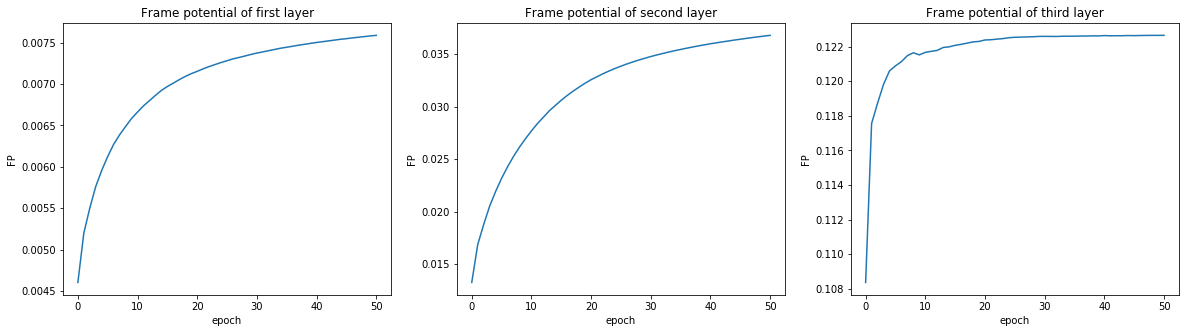

In [0]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, sharex=True, figsize=(20,5))
ax1.plot(frame_potentials['fc1'])
ax1.set_title('Frame potential of first layer')
ax1.set(xlabel='epoch', ylabel='FP')
ax2.plot(frame_potentials['fc2'])
ax2.set_title('Frame potential of second layer')
ax2.set(xlabel='epoch', ylabel='FP')
ax3.plot(frame_potentials['fc3'])
ax3.set_title('Frame potential of third layer')
ax3.set(xlabel='epoch', ylabel='FP')

### Analysis of the weight matrices

In [16]:
from snapshots import Snapshots

In [18]:
dir_name = "out/models/LeNet_300_100_21-10-2019_15:25:45"
epochs = list(range(20))
model_class = LeNet_300_100
s = Snapshots(dir_name, epochs, model_class, bias=False)

In [21]:
def weight_dist(dir_name, epochs, model_class, bias, layer):
    # Load model snapshots
    s = Snapshots(dir_name, epochs, model_class, bias)
    inner_products = s.compute_ips(layer).numpy()
    
    # Transform inner-products to distances between 0 and 1
    ips_mod = -0.5 * (inner_products - 1)
    kernel_width = ips_mod.mean()
    weights = np.exp(-ips_mod**2 / (kernel_width**2))
    thresh = np.exp(-0.5**2 / (kernel_width**2))
    
    # No self-loops
    for time in range(inner_products.shape[0]):
        for node_idx in range(inner_products.shape[1]):
            weights[time, node_idx, node_idx] = 0.
            
    # Plot weight distribution of generated adjacency matrix
    data = weights.flatten()
    fig, ((ax1, ax2)) = plt.subplots(1, 2, sharex=True, figsize=(20, 7))
    #fig = plt.figure(figsize=(12, 6))
    ax1.hist(data, bins=50)
    ax1.axvline(x=thresh, color='r', linestyle='dashed', linewidth=1.4, label="Orthogonal weight vectors")
    ax1.set_title('Distribution of entries of adjacency matrix')
    ax1.set_xlabel('Entry value')
    ax1.set_ylabel('Number of occurences')
    ax1.legend()
    
    ax2.hist(data, bins=50, density=True, histtype='step', cumulative=-1)
    ax2.axhline(y=0.05, color='g', linewidth=1.4, label="5% of entries")
    x_minor_ticks = np.linspace(0., 0.975, 40)
    y_minor_ticks = np.linspace(0.05, 1, 20)
    ax2.set_xticks(x_minor_ticks, minor=True)
    ax2.set_yticks(y_minor_ticks, minor=True)
    ax2.grid(which='both')
    ax2.set_title("Reversed CDF of approximated distribution")
    ax2.set_xlabel('Entry value')
    ax2.set_ylabel('Reverse CDF')
    ax2.legend()
    
    plt.show()
    return weights

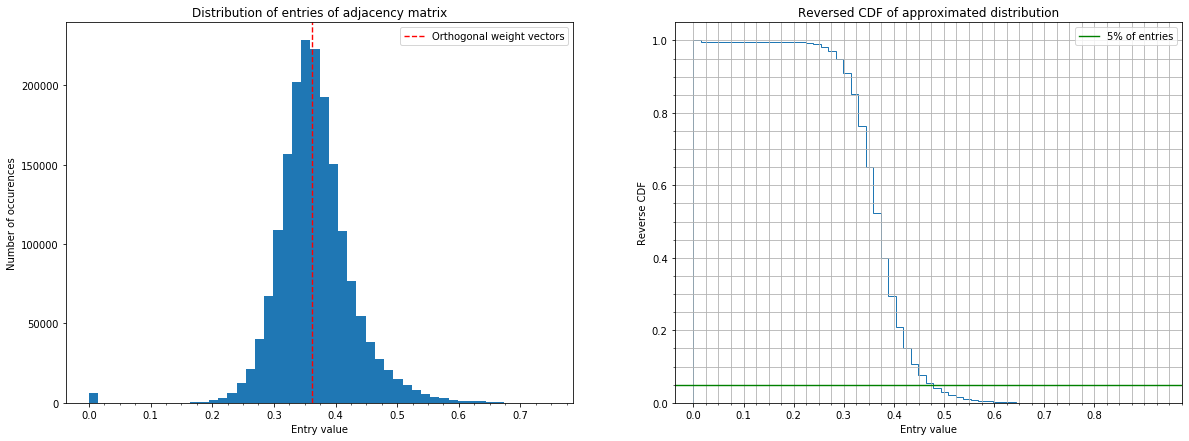

In [22]:
layer = "fc1"
weights = weight_dist(dir_name, epochs, model_class, False, layer)
weight_norms = s.compute_weight_norms(layer).numpy()

In [23]:
min_thresh = 0.45
step = 0.005
n_thresh = 55
max_thresh = min_thresh + (n_thresh-1)*step
thresholds = np.linspace(min_thresh, max_thresh, n_thresh)

In [24]:
thresholds

array([0.45 , 0.455, 0.46 , 0.465, 0.47 , 0.475, 0.48 , 0.485, 0.49 ,
       0.495, 0.5  , 0.505, 0.51 , 0.515, 0.52 , 0.525, 0.53 , 0.535,
       0.54 , 0.545, 0.55 , 0.555, 0.56 , 0.565, 0.57 , 0.575, 0.58 ,
       0.585, 0.59 , 0.595, 0.6  , 0.605, 0.61 , 0.615, 0.62 , 0.625,
       0.63 , 0.635, 0.64 , 0.645, 0.65 , 0.655, 0.66 , 0.665, 0.67 ,
       0.675, 0.68 , 0.685, 0.69 , 0.695, 0.7  , 0.705, 0.71 , 0.715,
       0.72 ])

In [25]:
n_cc_ls = []
for thresh in thresholds:
    w = weights.copy()
    w[w < thresh] = 0.
    n_models = w.shape[0]
    G = nx.from_numpy_matrix(w[n_models-1])
    n_connected = nx.number_connected_components(G)
    n_cc_ls.append(n_connected)
    #print(f"Threshold: {thresh}, Number of connected components: {n_connected}")

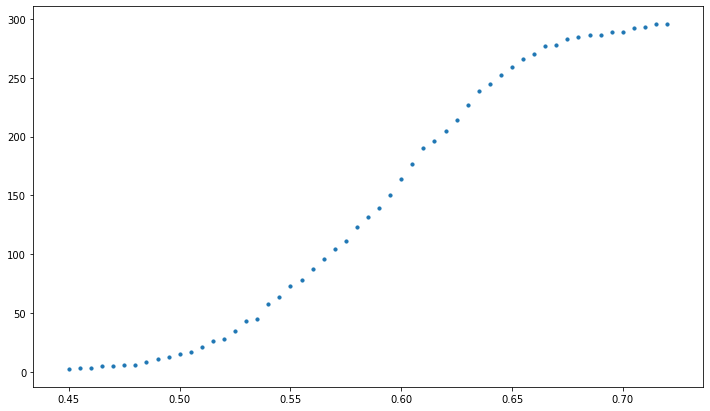

In [26]:
fig = plt.figure(figsize=(12,7))
plt.scatter(thresholds, n_cc_ls, s=10)
plt.show()

In [27]:
def training_graph(adjacency, weight_norms):
    graph = {}
    n_epochs = adjacency.shape[0]
    n_nodes = adjacency.shape[1]

    graph["nodes"] = []
    for node_id in range(n_nodes):
        norms = {str(epoch): float("{:.3f}".format(weight_norms[epoch, node_id])) for epoch in range(n_epochs)}
        node_entry = {"id": str(node_id), "fraction": norms}
        graph["nodes"].append(node_entry)

    graph["links"] = []
    for epoch in range(n_epochs):
        for i in range(n_nodes):
            for j in range(i+1, n_nodes):
                edge_weight = adjacency[epoch, i, j]
                if edge_weight:
                    edge_entry = {"source": str(i), "target": str(j), "value": float("{:.3f}".format(edge_weight)), "year": epoch}
                    graph["links"].append(edge_entry)
    
    return graph

In [32]:
w = weights.copy()
w[w < 0.580] = 0.
graph = training_graph(w, weight_norms)

In [33]:
import json
with open('viz/nn_graph.json', 'w') as fp:
    json.dump(graph, fp, indent=4)

In [30]:
n_models = weights.shape[0]
last_model = weights[n_models-1]
last_model_norms = weight_norms[n_models-1]

thresholds = np.arange(min_thresh, max_thresh, step)
plot_data = []

for thresh in thresholds:
    w = last_model.copy()
    w[w < thresh] = 0
    
    # Create a graph from sparse adjacency matrix
    G = nx.from_numpy_matrix(w)
    cc_ls = list(nx.connected_components(G))
    
    sizes = []
    magnitudes = []
    for connected_component in cc_ls:
        cc_size = len(connected_component)
        node_selection = list(connected_component)
        cc_max_mag = last_model_norms[node_selection].max()
        sizes.append(cc_size)
        magnitudes.append(cc_max_mag)
        
    plot_data.append((sizes, magnitudes))

In [31]:
# Cut-off Visualization
from ipywidgets import IntSlider, interact, fixed

int_slider = IntSlider(value=0, min=0, max=len(plot_data)-1)

def plot_figure(plot_data, thresholds, idx):
    fig = plt.figure(figsize=(12,7))
    x, y = plot_data[idx]
    plt.scatter(x, y)
    plt.title("Length vs max magnitude for cut-off {:.3f} ({} connected components)".format(thresholds[idx], len(x)))
    plt.xlabel("Connected component length")
    plt.ylabel("Max magnitude of node in connected component")
    

interact(plot_figure, plot_data=fixed(plot_data), thresholds=fixed(thresholds), idx=int_slider);

interactive(children=(IntSlider(value=0, description='idx', max=53), Output()), _dom_classes=('widget-interact…

In [256]:
thresh = 0.555

#### Biases

In [ ]:
b = s.get_biases(layer).numpy()

In [252]:
b_mean = b.mean(axis=0)
std_dev = b.std(axis=0)

epochs = b.shape[0]
n_nodes = b.shape[1]

In [255]:
int_slider = IntSlider(value=0, min=0, max=epochs-1)

def plot_figure(plot_data, idx):
    fig = plt.figure(figsize=(12,7))
    plt.hist(plot_data[idx], bins=20)
    plt.title("Title")
    plt.xlabel("x")
    plt.ylabel("y")
    
interact(plot_figure, plot_data=fixed(b), idx=int_slider);

interactive(children=(IntSlider(value=0, description='idx', max=9), Output()), _dom_classes=('widget-interact'…

In [266]:
n_models = weights.shape[0]
last_model = weights[n_models-1]
w = last_model.copy()
w[w < thresh] = 0
G = nx.from_numpy_matrix(w)
cc_ls = list(nx.connected_components(G))

In [267]:
last_b = b[epochs-1]
print("Last model bias standard deviation:", last_b.std())
for connected_component in cc_ls:
    cc_size = len(connected_component)
    node_selection = list(connected_component)
    cc_biases = last_b[node_selection]
    if cc_size > 1:
        std_dev = cc_biases.std()
        print(f"Size: {cc_size}, std_dev: {std_dev}")

Last model bias standard deviation: 0.02163267
Size: 214, std_dev: 0.02180653065443039
Size: 2, std_dev: 0.0013638203963637352
Size: 2, std_dev: 0.0005322825163602829
Size: 2, std_dev: 0.014326034113764763
Size: 2, std_dev: 0.018552163615822792
Size: 2, std_dev: 0.005734095349907875


### Pruning LeNet-300-100

In [17]:
layers = ['fc1']
exp_acc, exp_fps, pruning_accuracies, pruning_fps = mnist_pruning(testloader, layers, pruning_ratio=0.9, include_random=False, n_rounds=5, save_results=True)

Pruning using: max_fp_pruning

Test set: Average loss: 0.0747, Accuracy:   9821/ 10000 (98%)


Test set: Average loss: 0.0747, Accuracy:   9821/ 10000 (98%)


Test set: Average loss: 0.0747, Accuracy:   9821/ 10000 (98%)


Test set: Average loss: 0.0747, Accuracy:   9822/ 10000 (98%)


Test set: Average loss: 0.0747, Accuracy:   9821/ 10000 (98%)


Test set: Average loss: 0.0746, Accuracy:   9822/ 10000 (98%)


Test set: Average loss: 0.0747, Accuracy:   9823/ 10000 (98%)


Test set: Average loss: 0.0747, Accuracy:   9823/ 10000 (98%)


Test set: Average loss: 0.0748, Accuracy:   9822/ 10000 (98%)


Test set: Average loss: 0.0748, Accuracy:   9822/ 10000 (98%)


Test set: Average loss: 0.0749, Accuracy:   9823/ 10000 (98%)

Pruning round: [ 10/270 (4%)]

Test set: Average loss: 0.0748, Accuracy:   9819/ 10000 (98%)


Test set: Average loss: 0.0746, Accuracy:   9819/ 10000 (98%)


Test set: Average loss: 0.0745, Accuracy:   9819/ 10000 (98%)


Test set: Average loss: 0.0744, Accuracy:  

In [0]:
fname_exp_acc = "out/metrics/pruning/LeNet_300_100_fc1_random_pruning_0.9_acc_14-10-2019_12:59:03.npy"
fname_exp_fps = "out/metrics/pruning/LeNet_300_100_fc1_random_pruning_0.9_fp_14-10-2019_12:59:03.npy"
fname_pruning_acc = "out/metrics/pruning/LeNet_300_100_fc1_combined_0.9_acc_15-10-2019_07:55:34.npy"  
fname_pruning_fps = "out/metrics/pruning/LeNet_300_100_fc1_combined_0.9_fp_15-10-2019_07:55:34.npy"  

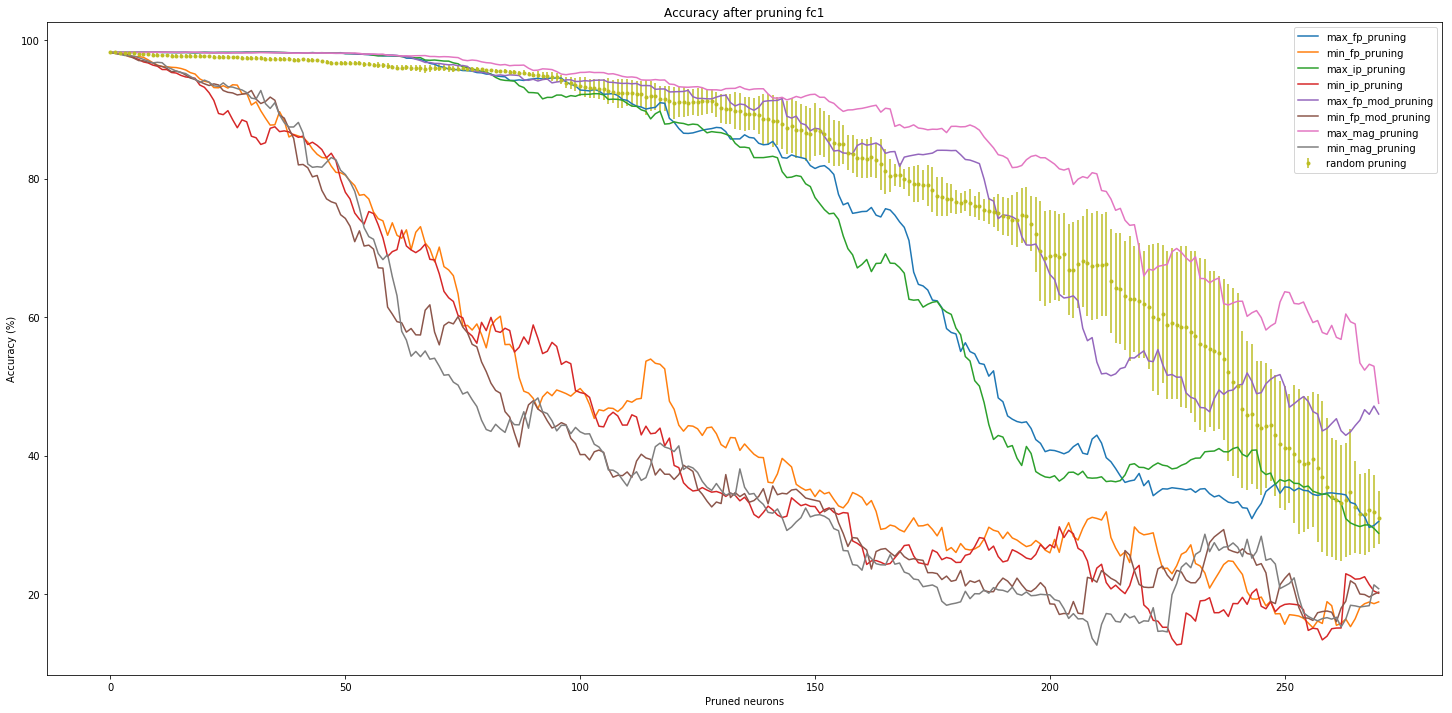

In [21]:
draw_acc_plot('fc1', fname_exp_acc, fname_pruning_acc, fig_name="LeNet_300_100_fc1_combined_0.9_acc_15-10-2019_07:55:34")

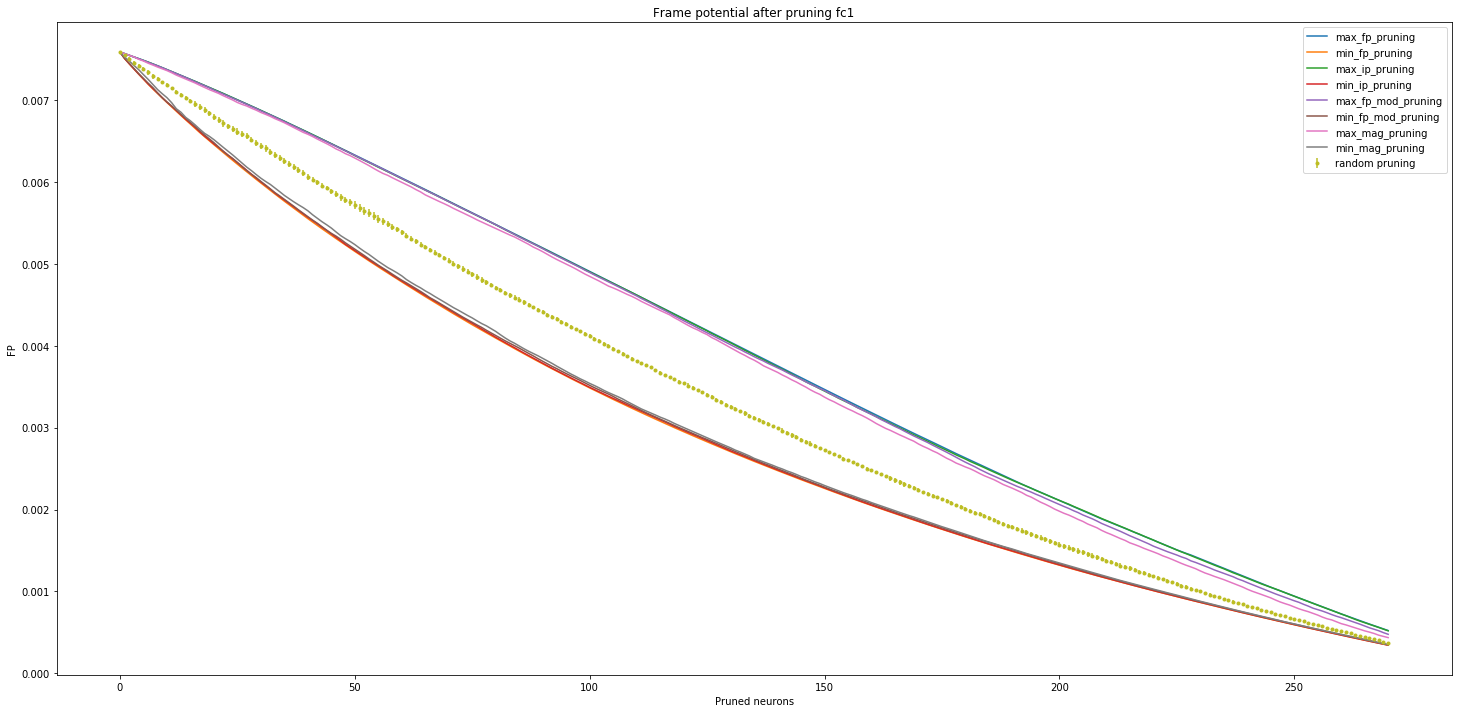

In [22]:
draw_fps_plot('fc1', fname_exp_fps, fname_pruning_fps, fig_name="LeNet_300_100_fc1_combined_0.9_fp_15-10-2019_07:55:34")

In [23]:
layers = ['fc2']
exp_acc, exp_fps, pruning_accuracies, pruning_fps = mnist_pruning(testloader, layers, pruning_ratio=0.9, include_random=True, n_rounds=5, save_results=True)

Random pruning experiment:

Random pruning experiment N° 1

Test set: Average loss: 0.0747, Accuracy:   9821/ 10000 (98%)


Test set: Average loss: 0.0792, Accuracy:   9812/ 10000 (98%)


Test set: Average loss: 0.0839, Accuracy:   9805/ 10000 (98%)


Test set: Average loss: 0.0839, Accuracy:   9805/ 10000 (98%)


Test set: Average loss: 0.0805, Accuracy:   9806/ 10000 (98%)


Test set: Average loss: 0.0783, Accuracy:   9811/ 10000 (98%)


Test set: Average loss: 0.0806, Accuracy:   9805/ 10000 (98%)


Test set: Average loss: 0.0840, Accuracy:   9795/ 10000 (98%)


Test set: Average loss: 0.0838, Accuracy:   9792/ 10000 (98%)


Test set: Average loss: 0.0835, Accuracy:   9793/ 10000 (98%)


Test set: Average loss: 0.0804, Accuracy:   9793/ 10000 (98%)

Pruning round: [ 10/ 90 (11%)]

Test set: Average loss: 0.0805, Accuracy:   9796/ 10000 (98%)


Test set: Average loss: 0.0808, Accuracy:   9794/ 10000 (98%)


Test set: Average loss: 0.0947, Accuracy:   9766/ 10000 (98%)


Test set: Ave

In [0]:
fname_exp_acc = "out/metrics/pruning/LeNet_300_100_fc2_random_pruning_0.9_acc_15-10-2019_08:12:16.npy"
fname_exp_fps = "out/metrics/pruning/LeNet_300_100_fc2_random_pruning_0.9_fp_15-10-2019_08:12:16.npy"
fname_pruning_acc = "out/metrics/pruning/LeNet_300_100_fc2_combined_0.9_acc_15-10-2019_08:33:28.npy"
fname_pruning_fps = "out/metrics/pruning/LeNet_300_100_fc2_combined_0.9_fp_15-10-2019_08:33:28.npy"

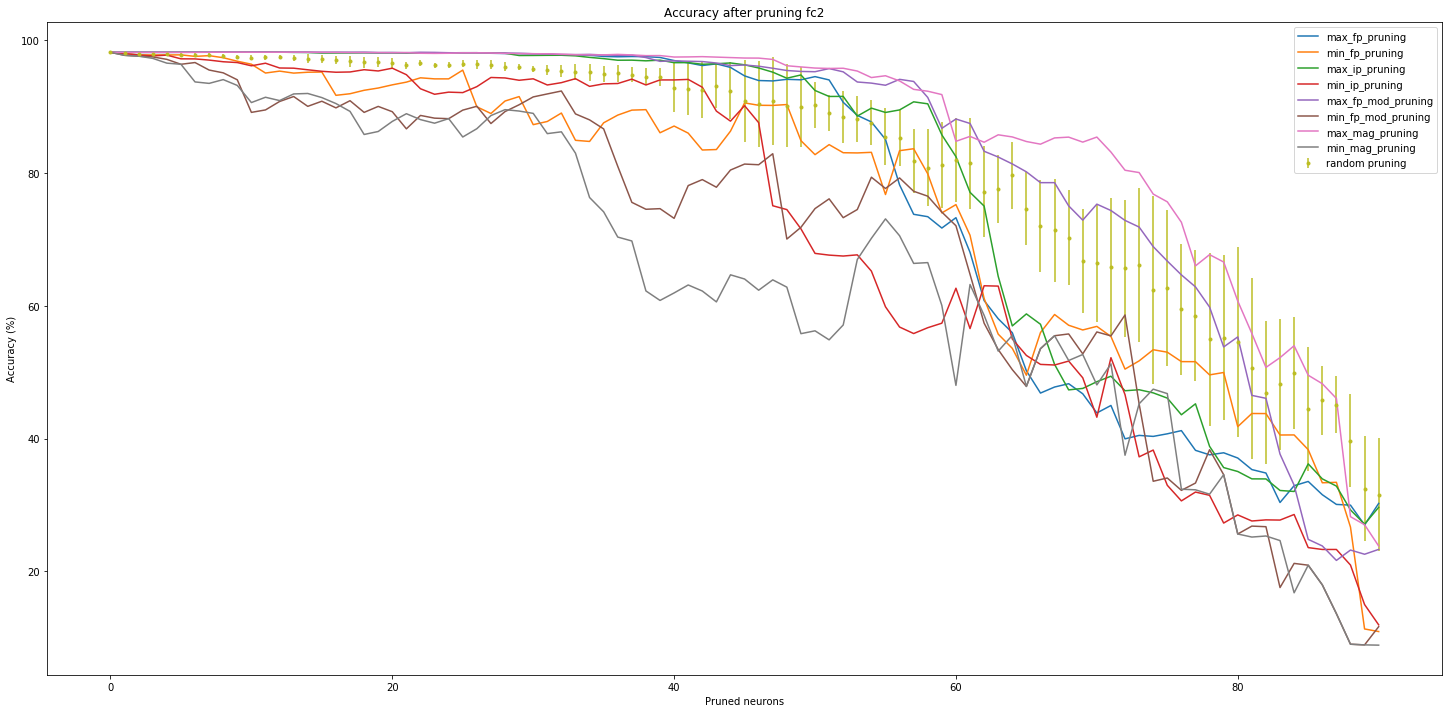

In [33]:
draw_acc_plot('fc2', fname_exp_acc, fname_pruning_acc, fig_name="LeNet_300_100_fc2_combined_0.9_acc_15-10-2019_08:33:28")

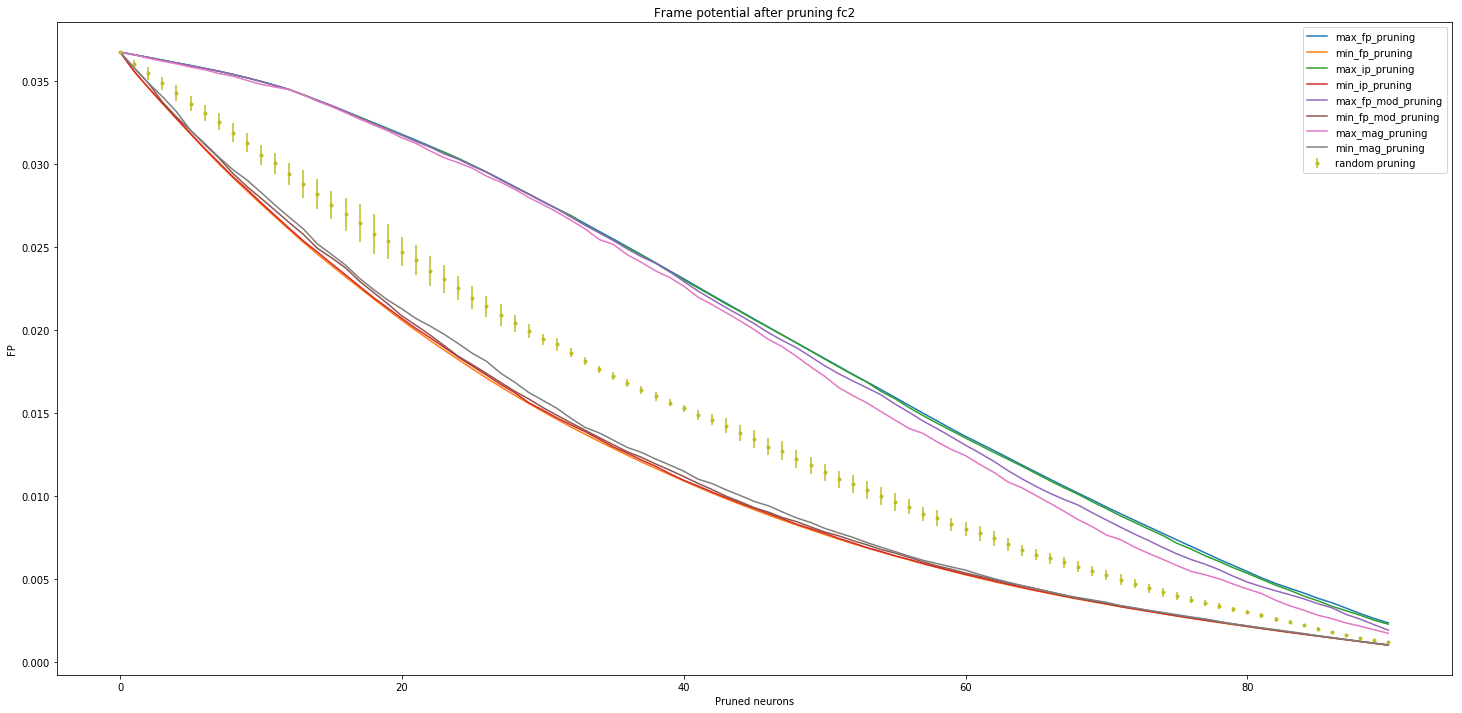

In [34]:
draw_fps_plot('fc2', fname_exp_fps, fname_pruning_fps, fig_name="LeNet_300_100_fc2_combined_0.9_fp_15-10-2019_08:33:28")

#### Pruning schedules

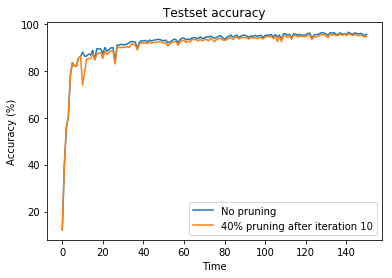

In [0]:
plt.plot(accuracies[0], label="No pruning")
plt.plot(accuracies[10], label="40% pruning after iteration 10")
plt.title('Testset accuracy')
plt.xlabel('Time')
plt.ylabel('Accuracy (%)')
plt.legend(loc="best")
plt.show()

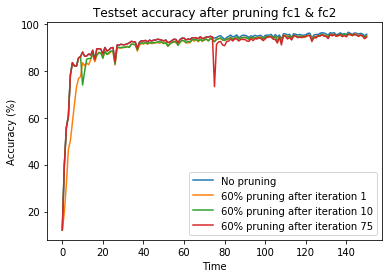

In [0]:
plt.plot(accuracies[0], label="No pruning")
plt.plot(accuracies[1], label="60% pruning after iteration 1")
plt.plot(accuracies[10], label="60% pruning after iteration 10")
plt.plot(accuracies[75], label="60% pruning after iteration 75")
plt.title('Testset accuracy after pruning fc1 & fc2')
plt.xlabel('Time')
plt.ylabel('Accuracy (%)')
plt.legend(loc="best")
plt.show()

### Show images, compare class results

In [0]:
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%9s' % classes[labels[j]] for j in range(4)))

In [0]:
print(images.shape)
print(labels.shape)

torch.Size([4, 1, 28, 28])
torch.Size([4])


In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: \n', ' '.join('%9s' % classes[labels[j]] for j in range(4)))

In [0]:
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: \n', ' '.join('%9s' % classes[predicted[j]]
                              for j in range(4)))

Predicted: 
         7         2         1         0


In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 97 %


In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of 0 : 98 %
Accuracy of 1 : 97 %
Accuracy of 2 : 89 %
Accuracy of 3 : 96 %
Accuracy of 4 : 100 %
Accuracy of 5 : 92 %
Accuracy of 6 : 94 %
Accuracy of 7 : 96 %
Accuracy of 8 : 98 %
Accuracy of 9 : 97 %


## CIFAR-10 / Conv-2

### Loading the data

In [0]:
train_batch_size = 64
test_batch_size = 1000

In [17]:
trainloader, testloader, classes = get_cifar(train_batch_size, test_batch_size)

Files already downloaded and verified
Files already downloaded and verified


### Training the model

In [0]:
epochs = 10
optim_kwargs = {'lr': 0.0002}

In [0]:
model = Conv2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), **optim_kwargs)
e = Experiment(model, criterion, optimizer, optim_kwargs)
monitored = ['conv1', 'conv2', 'fc1', 'fc2']

In [0]:
test_accuracies = e.fit(trainloader, testloader, epochs, monitored=monitored, save_results=False)


Test set: Average loss: 2.3042, Accuracy:    990/ 10000 (10%)

Train Epoch:   1 [     0/ 50000 (0%)]	Loss: 2.303776
Train Epoch:   1 [  6400/ 50000 (13%)]	Loss: 1.684943
Train Epoch:   1 [ 12800/ 50000 (26%)]	Loss: 1.365785
Train Epoch:   1 [ 19200/ 50000 (38%)]	Loss: 1.493198
Train Epoch:   1 [ 25600/ 50000 (51%)]	Loss: 1.192232
Train Epoch:   1 [ 32000/ 50000 (64%)]	Loss: 1.458461
Train Epoch:   1 [ 38400/ 50000 (77%)]	Loss: 1.368468
Train Epoch:   1 [ 44800/ 50000 (90%)]	Loss: 1.346755

Test set: Average loss: 1.1631, Accuracy:   5931/ 10000 (59%)

Train Epoch:   2 [     0/ 50000 (0%)]	Loss: 1.098188
Train Epoch:   2 [  6400/ 50000 (13%)]	Loss: 1.081247
Train Epoch:   2 [ 12800/ 50000 (26%)]	Loss: 0.989488
Train Epoch:   2 [ 19200/ 50000 (38%)]	Loss: 1.161585
Train Epoch:   2 [ 25600/ 50000 (51%)]	Loss: 0.996538
Train Epoch:   2 [ 32000/ 50000 (64%)]	Loss: 1.182470
Train Epoch:   2 [ 38400/ 50000 (77%)]	Loss: 1.067997
Train Epoch:   2 [ 44800/ 50000 (90%)]	Loss: 1.107387

Test set:

[Text(0, 0.5, 'FP'), Text(0.5, 0, 'epoch')]

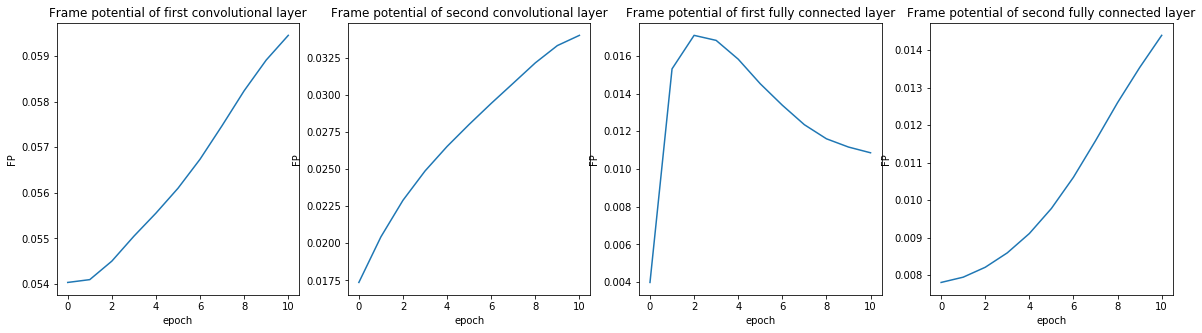

In [0]:
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, sharex=True, figsize=(20,5))
ax1.plot(frame_potentials['conv1'])
ax1.set_title('Frame potential of first convolutional layer')
ax1.set(xlabel='epoch', ylabel='FP')
ax2.plot(frame_potentials['conv2'])
ax2.set_title('Frame potential of second convolutional layer')
ax2.set(xlabel='epoch', ylabel='FP')
ax3.plot(frame_potentials['fc1'])
ax3.set_title('Frame potential of first fully connected layer')
ax3.set(xlabel='epoch', ylabel='FP')
ax4.plot(frame_potentials['fc2'])
ax4.set_title('Frame potential of second fully connected layer')
ax4.set(xlabel='epoch', ylabel='FP')

### Pruning Conv2

In [0]:
layers = ['fc1', 'fc2']
exp_acc, exp_fps, pruning_accuracies, pruning_fps = cifar_pruning(testloader, layers, pruning_ratio=0.9, include_random=False, n_rounds=2, save_results=True)

Pruning using: max_fp_pruning

Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)

Pruning round: [ 10/230 (4%)]

Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:  

In [0]:
fname_exp_acc = ""
fname_exp_fps = ""
fname_pruning_acc = "out/metrics/pruning/Conv2_fc1_combined_0.9_acc_13-10-2019_14:17:35.npy"
fname_pruning_fps = "out/metrics/pruning/Conv2_fc1_combined_0.9_fp_13-10-2019_14:17:35.npy"

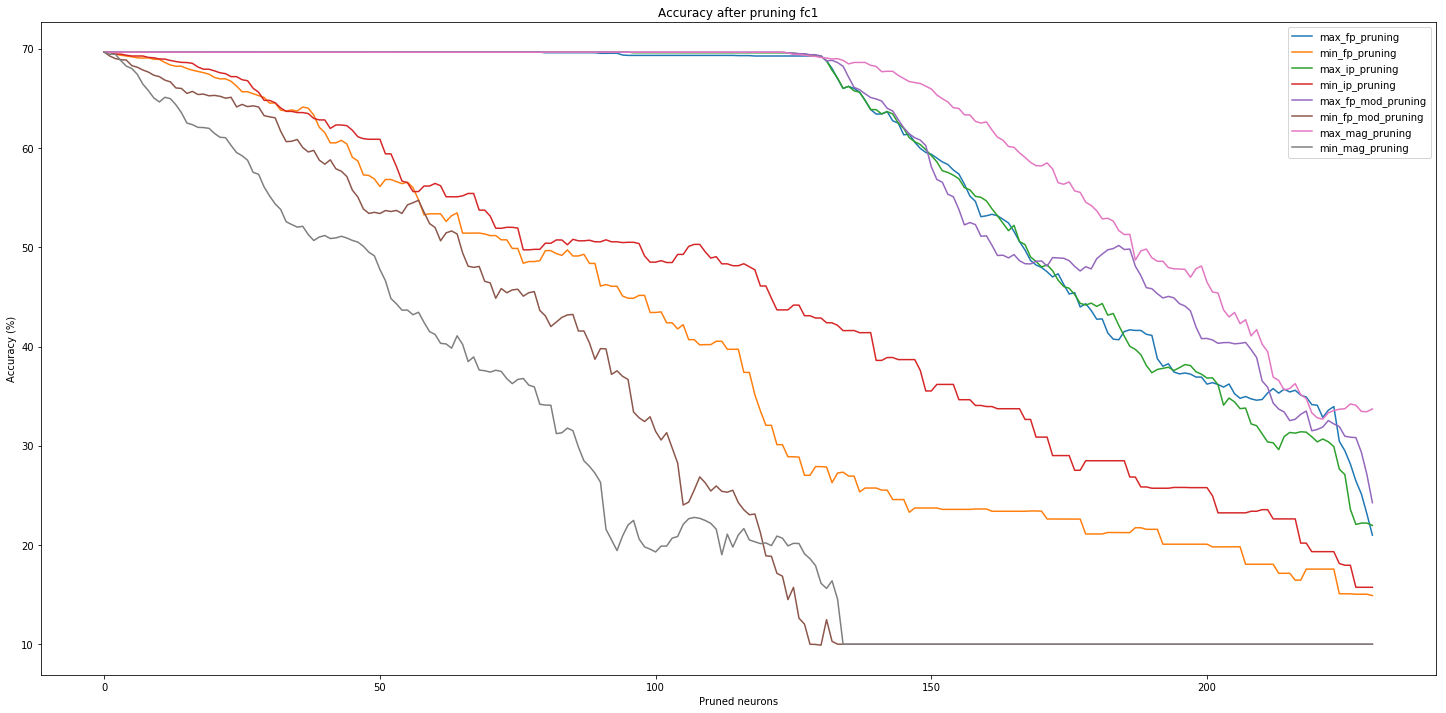

In [0]:
draw_acc_plot('fc1', fname_exp_acc, fname_pruning_acc, fig_name="Conv2_fc1_combined_0.9_acc_13-10-2019_14:17:35")

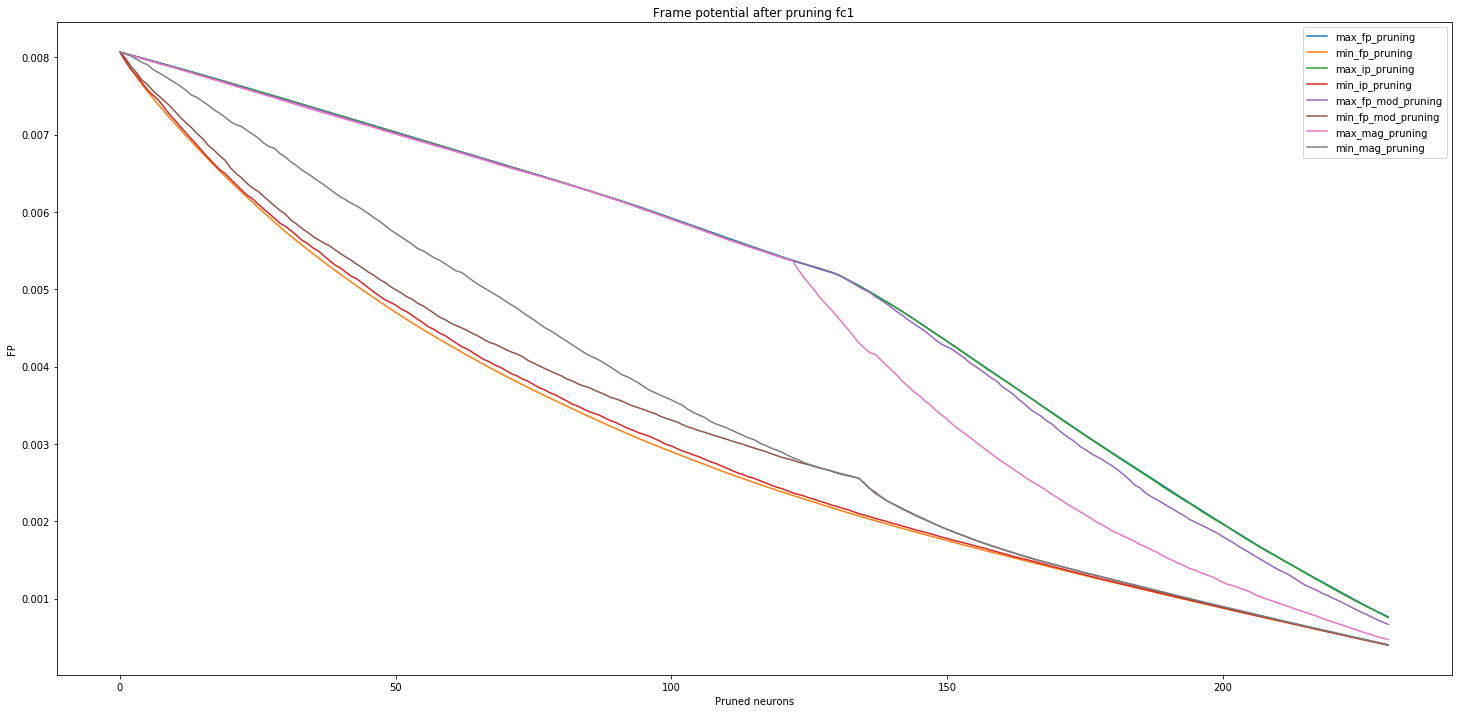

In [0]:
draw_fps_plot('fc1', fname_exp_fps, fname_pruning_fps, fig_name="Conv2_fc1_combined_0.9_fp_13-10-2019_14:17:35")

In [0]:
fname_exp_acc = ""
fname_exp_fps = ""
fname_pruning_acc = "out/metrics/pruning/Conv2_fc2_combined_0.9_acc_13-10-2019_15:30:05.npy"
fname_pruning_fps = "out/metrics/pruning/Conv2_fc2_combined_0.9_fp_13-10-2019_15:30:05.npy"

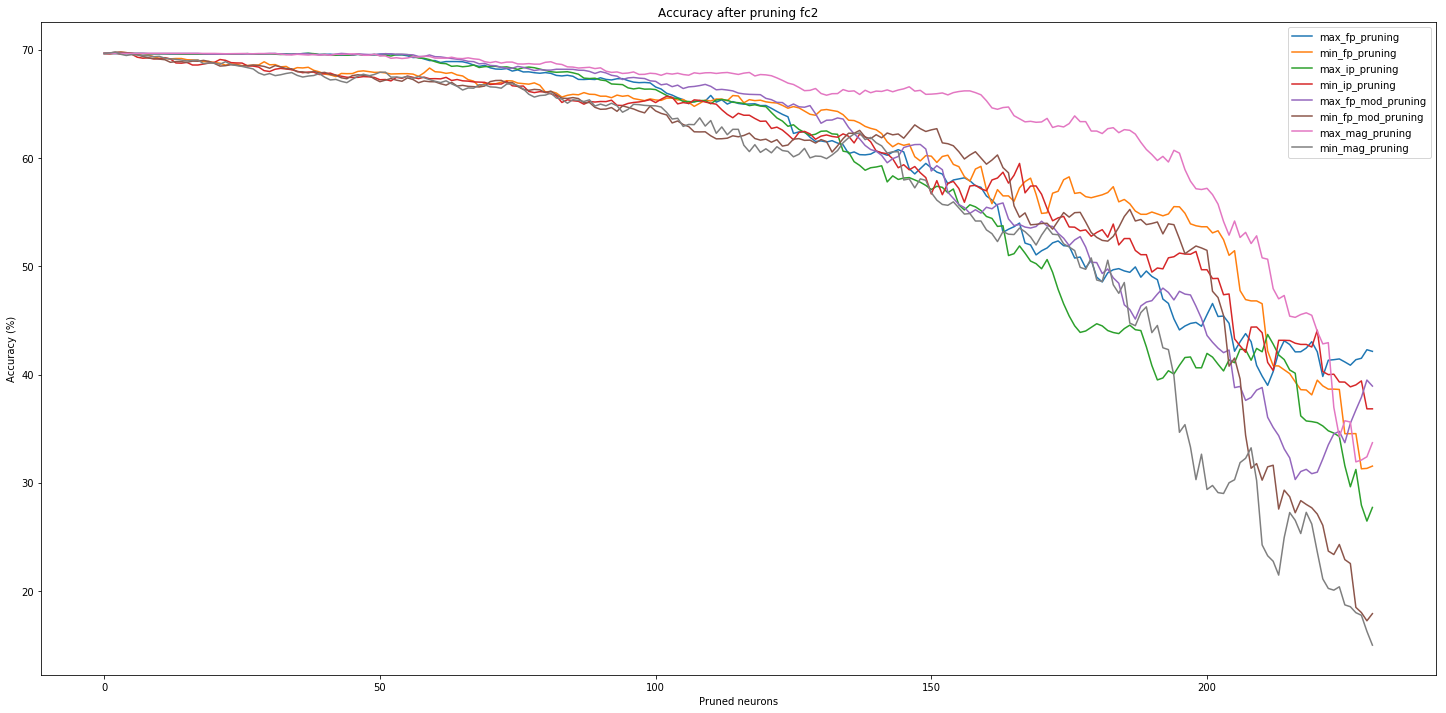

In [0]:
draw_acc_plot('fc2', fname_exp_acc, fname_pruning_acc, fig_name="Conv2_fc2_combined_0.9_acc_13-10-2019_15:30:05")

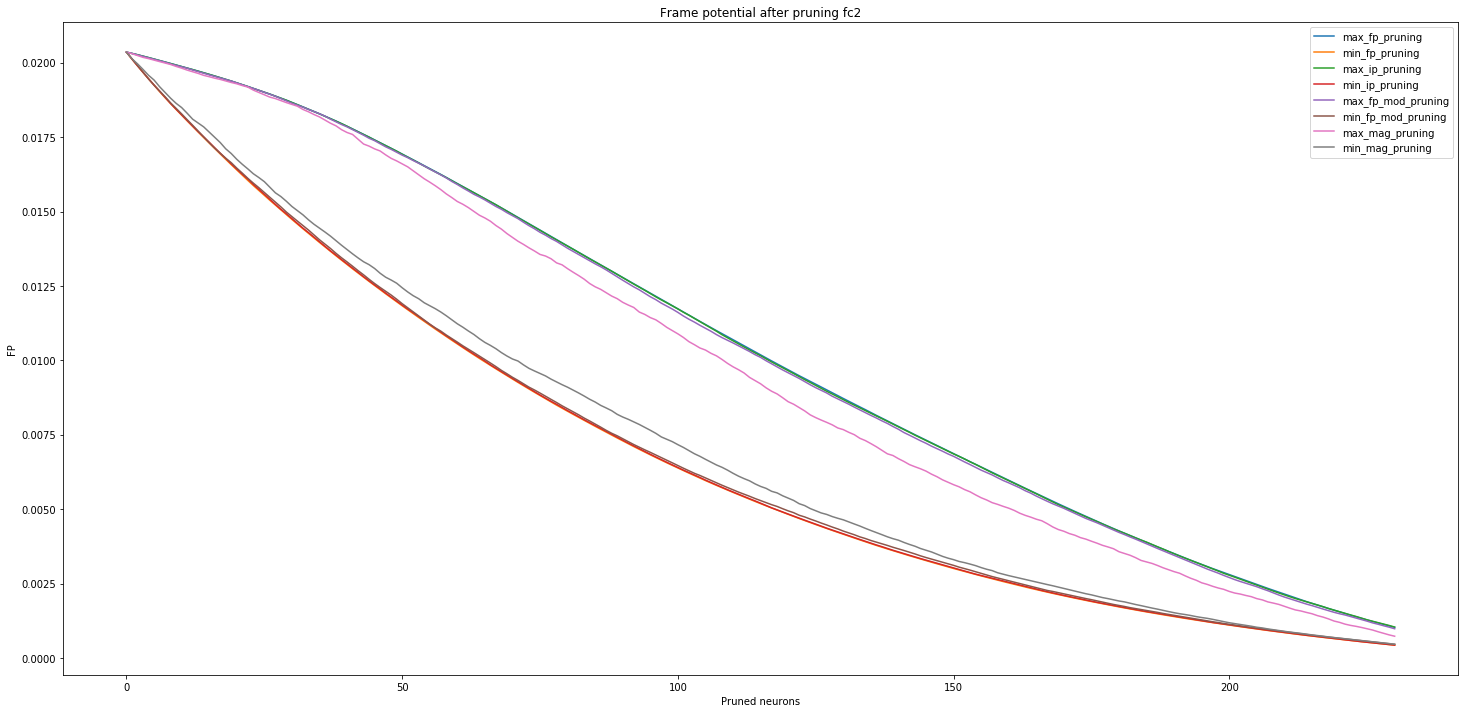

In [0]:
draw_fps_plot('fc2', fname_exp_fps, fname_pruning_fps, fig_name="Conv2_fc2_combined_0.9_fp_13-10-2019_15:30:05")

In [0]:
layers = ['conv1', 'conv2']
exp_acc, exp_fps, pruning_accuracies, pruning_fps = cifar_pruning(testloader, layers, pruning_ratio=0.9, include_random=True, n_rounds=5, save_results=True)

Random pruning experiment:

Random pruning experiment N° 1

Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2000, Accuracy:   6957/ 10000 (70%)


Test set: Average loss: 2.1510, Accuracy:   6914/ 10000 (69%)


Test set: Average loss: 2.1426, Accuracy:   6914/ 10000 (69%)


Test set: Average loss: 2.0882, Accuracy:   6914/ 10000 (69%)


Test set: Average loss: 2.0720, Accuracy:   6888/ 10000 (69%)


Test set: Average loss: 2.0417, Accuracy:   6882/ 10000 (69%)


Test set: Average loss: 2.0114, Accuracy:   6844/ 10000 (68%)


Test set: Average loss: 1.9873, Accuracy:   6827/ 10000 (68%)


Test set: Average loss: 1.9550, Accuracy:   6818/ 10000 (68%)


Test set: Average loss: 1.9136, Accuracy:   6798/ 10000 (68%)

Pruning round: [ 10/ 57 (18%)]

Test set: Average loss: 1.8687, Accuracy:   6813/ 10000 (68%)


Test set: Average loss: 1.8958, Accuracy:   6792/ 10000 (68%)


Test set: Average loss: 1.9100, Accuracy:   6774/ 10000 (68%)


Test set: Ave

In [0]:
fname_exp_acc = "out/metrics/pruning/Conv2_conv1_random_pruning_0.9_acc_13-10-2019_15:41:15.npy"
fname_exp_fps = "out/metrics/pruning/Conv2_conv1_random_pruning_0.9_fp_13-10-2019_15:41:15.npy"
fname_pruning_acc = "out/metrics/pruning/Conv2_conv1_combined_0.9_acc_13-10-2019_15:59:18.npy"
fname_pruning_fps = "out/metrics/pruning/Conv2_conv1_combined_0.9_fp_13-10-2019_15:59:18.npy"

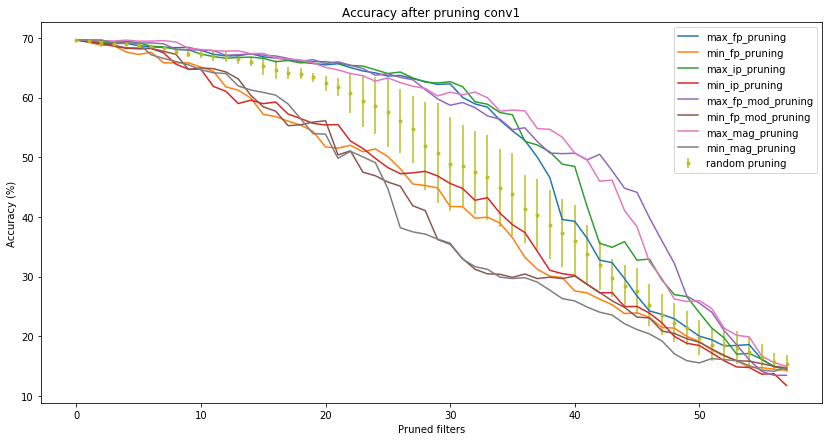

In [0]:
draw_acc_plot('conv1', fname_exp_acc, fname_pruning_acc, figsize=(14, 7), fig_name="Conv2_conv1_combined_0.9_acc_13-10-2019_15:59:18")

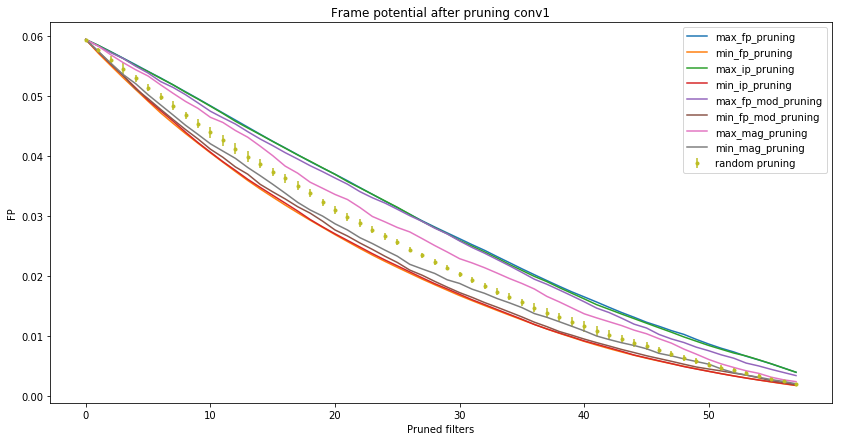

In [0]:
draw_fps_plot('conv1', fname_exp_fps, fname_pruning_fps, figsize=(14, 7), fig_name="Conv2_conv1_combined_0.9_fp_13-10-2019_15:59:18")

In [0]:
fname_exp_acc = "out/metrics/pruning/Conv2_conv2_random_pruning_0.9_acc_13-10-2019_16:10:29.npy"
fname_exp_fps = "out/metrics/pruning/Conv2_conv2_random_pruning_0.9_fp_13-10-2019_16:10:29.npy"
fname_pruning_acc = "out/metrics/pruning/Conv2_conv2_combined_0.9_acc_13-10-2019_16:28:55.npy"
fname_pruning_fps = "out/metrics/pruning/Conv2_conv2_combined_0.9_fp_13-10-2019_16:28:55.npy"

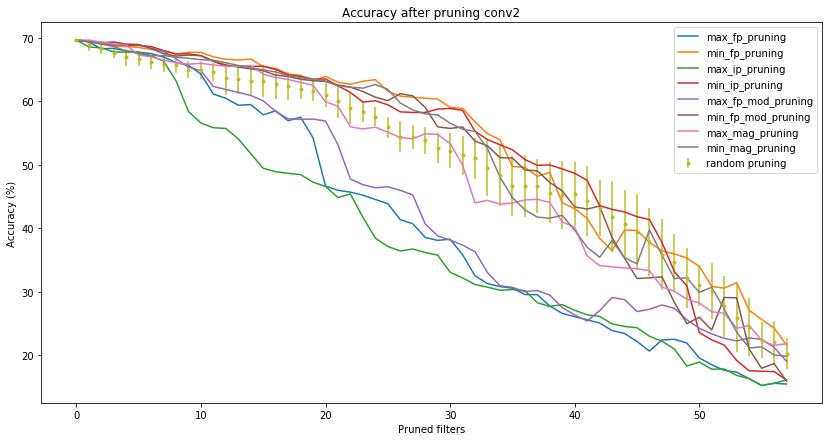

In [0]:
draw_acc_plot('conv2', fname_exp_acc, fname_pruning_acc, figsize=(14, 7), fig_name="Conv2_conv2_combined_0.9_acc_13-10-2019_16:28:55")

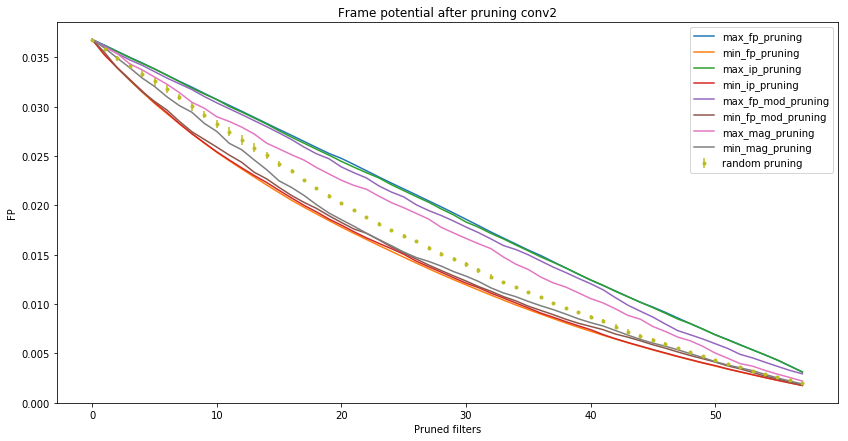

In [0]:
draw_fps_plot('conv2', fname_exp_fps, fname_pruning_fps, figsize=(14, 7), fig_name="Conv2_conv2_combined_0.9_fp_13-10-2019_16:28:55")

#### Pruning schedules

In [20]:
layers = ['fc1']
pruning = prune.max_mag_pruning
pruning_ratios = [0.3, 0.6, 0.9]
accuracies, frame_potentials = cifar_scheduling(testloader, layers, pruning, pruning_ratios, save_results=True)


Test set: Average loss: 2.3042, Accuracy:    990/ 10000 (10%)


Test set: Average loss: 2.3049, Accuracy:    880/ 10000 (9%)

Evaluating model accuracies [  1/ 75]

Test set: Average loss: 1.8126, Accuracy:   3434/ 10000 (34%)


Test set: Average loss: 1.8478, Accuracy:   3241/ 10000 (32%)


Test set: Average loss: 1.8126, Accuracy:   3434/ 10000 (34%)

Evaluating model accuracies [  2/ 75]

Test set: Average loss: 1.6719, Accuracy:   4033/ 10000 (40%)


Test set: Average loss: 1.6899, Accuracy:   3982/ 10000 (40%)


Test set: Average loss: 1.6768, Accuracy:   4009/ 10000 (40%)

Evaluating model accuracies [  3/ 75]

Test set: Average loss: 1.5763, Accuracy:   4366/ 10000 (44%)


Test set: Average loss: 1.6074, Accuracy:   4342/ 10000 (43%)


Test set: Average loss: 1.5904, Accuracy:   4328/ 10000 (43%)

Evaluating model accuracies [  4/ 75]

Test set: Average loss: 1.5108, Accuracy:   4517/ 10000 (45%)


Test set: Average loss: 1.5233, Accuracy:   4467/ 10000 (45%)


Test set: Averag

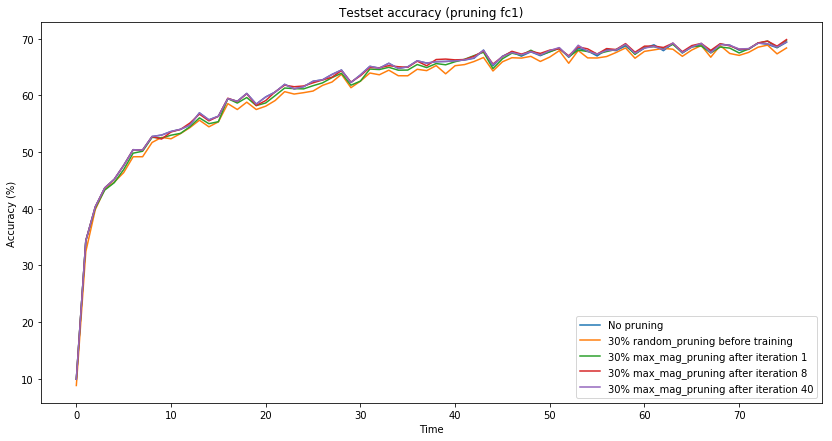

In [30]:
acc_fname = "out/metrics/pruning/Conv2_fc1_scheduled-pruning_0.3_acc_15-10-2019_10:47:44.npy"
draw_sched_plot('fc1', acc_fname, "max_mag_pruning", pruning_ratio=0.3, figsize=(14, 7), fig_name="Conv2_fc1_scheduled-pruning_0.3_acc_15-10-2019_10:47:44")

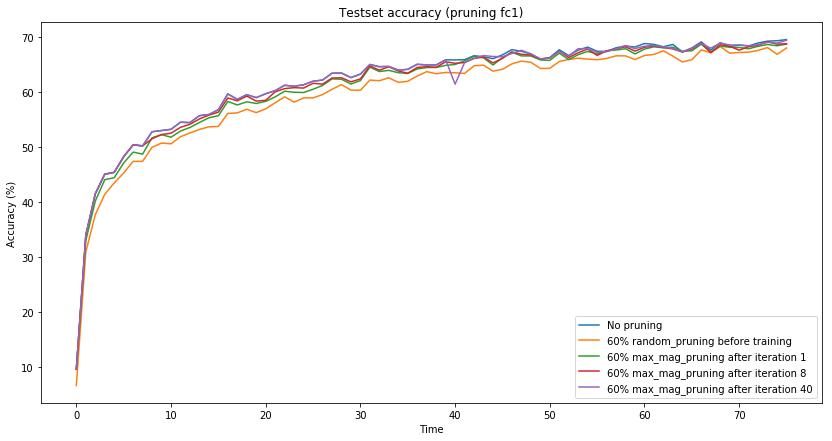

In [31]:
acc_fname = "out/metrics/pruning/Conv2_fc1_scheduled-pruning_0.6_acc_15-10-2019_10:15:57.npy"
draw_sched_plot('fc1', acc_fname, "max_mag_pruning", pruning_ratio=0.6, figsize=(14, 7), fig_name="Conv2_fc1_scheduled-pruning_0.6_acc_15-10-2019_10:15:57")

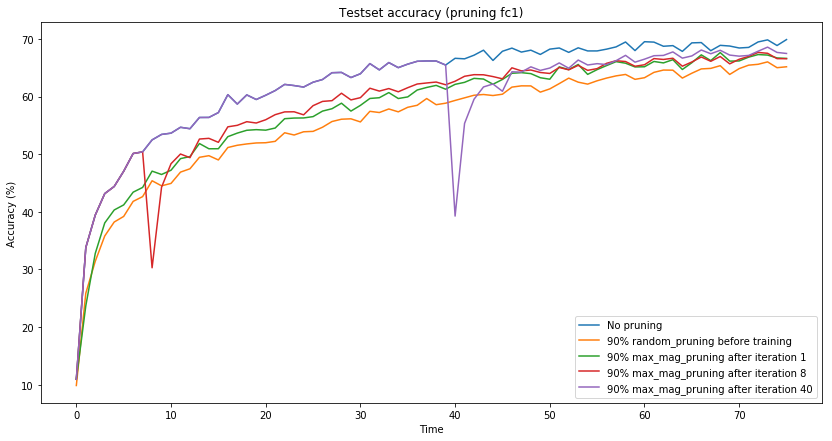

In [32]:
acc_fname = "out/metrics/pruning/Conv2_fc1_scheduled-pruning_0.9_acc_15-10-2019_11:05:46.npy"
draw_sched_plot('fc1', acc_fname, "max_mag_pruning", pruning_ratio=0.9, figsize=(14, 7), fig_name="Conv2_fc1_scheduled-pruning_0.9_acc_15-10-2019_11:05:46")

In [25]:
layers = ['fc2']
pruning = prune.max_mag_pruning
pruning_ratios = [0.3, 0.6, 0.9]
accuracies, frame_potentials = cifar_scheduling(testloader, layers, pruning, pruning_ratios, save_results=True)


Test set: Average loss: 2.3026, Accuracy:   1199/ 10000 (12%)


Test set: Average loss: 2.3027, Accuracy:   1224/ 10000 (12%)

Evaluating model accuracies [  1/ 75]

Test set: Average loss: 1.8262, Accuracy:   3334/ 10000 (33%)


Test set: Average loss: 1.8714, Accuracy:   3217/ 10000 (32%)


Test set: Average loss: 1.9137, Accuracy:   3072/ 10000 (31%)

Evaluating model accuracies [  2/ 75]

Test set: Average loss: 1.7107, Accuracy:   3914/ 10000 (39%)


Test set: Average loss: 1.6954, Accuracy:   3990/ 10000 (40%)


Test set: Average loss: 1.7192, Accuracy:   3915/ 10000 (39%)

Evaluating model accuracies [  3/ 75]

Test set: Average loss: 1.5736, Accuracy:   4448/ 10000 (44%)


Test set: Average loss: 1.6033, Accuracy:   4384/ 10000 (44%)


Test set: Average loss: 1.6197, Accuracy:   4240/ 10000 (42%)

Evaluating model accuracies [  4/ 75]

Test set: Average loss: 1.5050, Accuracy:   4569/ 10000 (46%)


Test set: Average loss: 1.5182, Accuracy:   4537/ 10000 (45%)


Test set: Avera

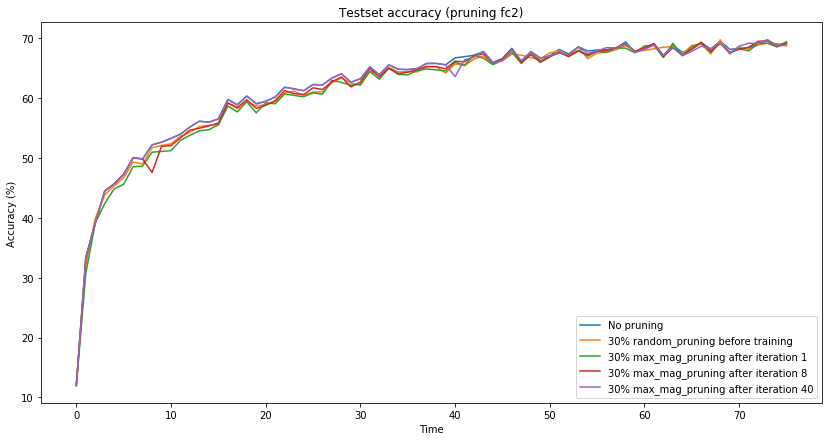

In [33]:
acc_fname = "out/metrics/pruning/Conv2_fc2_scheduled-pruning_0.3_acc_15-10-2019_11:28:03.npy"
draw_sched_plot('fc2', acc_fname, "max_mag_pruning", pruning_ratio=0.3, figsize=(14, 7), fig_name="Conv2_fc2_scheduled-pruning_0.3_acc_15-10-2019_11:28:03")

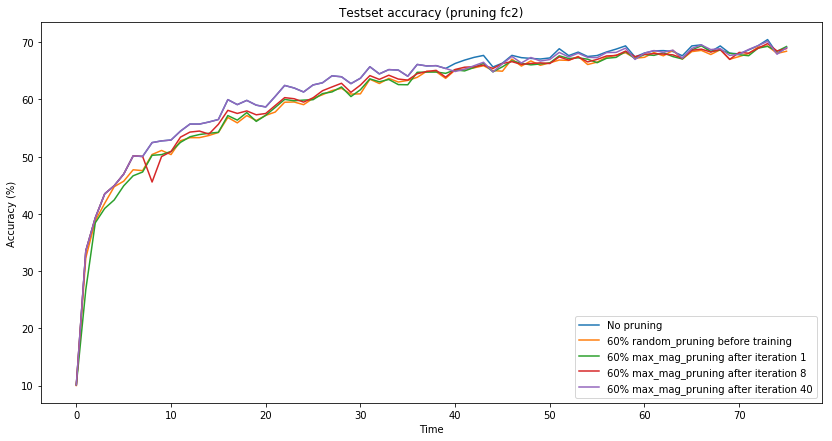

In [34]:
acc_fname = "out/metrics/pruning/Conv2_fc2_scheduled-pruning_0.6_acc_15-10-2019_11:45:38.npy"
draw_sched_plot('fc2', acc_fname, "max_mag_pruning", pruning_ratio=0.6, figsize=(14, 7), fig_name="Conv2_fc2_scheduled-pruning_0.6_acc_15-10-2019_11:45:38")

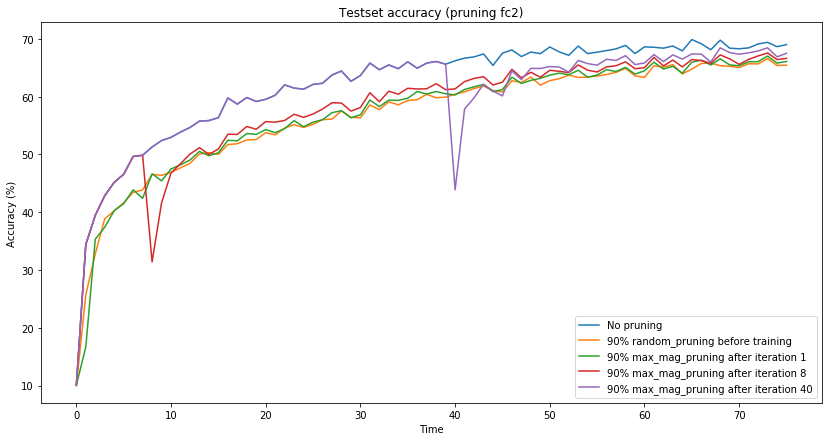

In [35]:
acc_fname = "out/metrics/pruning/Conv2_fc2_scheduled-pruning_0.9_acc_15-10-2019_12:03:41.npy"
draw_sched_plot('fc2', acc_fname, "max_mag_pruning", pruning_ratio=0.9, figsize=(14, 7), fig_name="Conv2_fc2_scheduled-pruning_0.9_acc_15-10-2019_12:03:41")

### Show images, compare class results

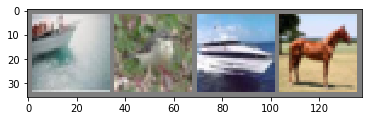

 ship  bird  ship horse


In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 69 %


In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 52 %
Accuracy of   car : 65 %
Accuracy of  bird : 51 %
Accuracy of   cat : 46 %
Accuracy of  deer : 53 %
Accuracy of   dog : 20 %
Accuracy of  frog : 49 %
Accuracy of horse : 59 %
Accuracy of  ship : 79 %
Accuracy of truck : 57 %
